## **⚠️ Important:**  

### Downloading the Datasets  

Before proceeding, you need to download the datasets. Visit the following [link](https://uofc-my.sharepoint.com/:f:/g/personal/ahmed_aboulfotouh_ucalgary_ca/EoNyesd8BQFDqwm4GVN3bWQBLmtX55MU-cgn_9W4OjNdAA?e=AFwtZK), where you will find three directories:  

- `radio_signal_identification`  
- `human_activity_sensing`  
- `5g_positioning`  

We recommend creating a directory named **`data`** in your working directory and organizing the datasets into three subdirectories with the same names.  


### Downloading the Models  

Next, download the pretrained models from this [link](https://uofc-my.sharepoint.com/:f:/g/personal/ahmed_aboulfotouh_ucalgary_ca/Ejr2YYjJZrpFkXuUo61y-38BEwEKxiPYMGbIcrhJhGeMyQ?e=NfpIvC). There are three different models, varying in size:  

- **Small**: `pretrained_small_75.pth`  
- **Medium**: `pretrained_medium_75.pth`  
- **Large**: `pretrained_large_75.pth`  

We recommend using the **small model** for fine-tuning; however, feel free to experiment with other model sizes.  

For organization, we suggest creating a **`checkpoints`** directory in your working directory to store the pretrained models.

# Radio Foundation Models Lab

![Radio Foundation Model](https://drive.google.com/uc?export=view&id=1QwFZSPN28VRSRgCoT-1m75MWaGfsqhtp)

In this lab, we will fine-tune a pretrained radio foundation model with a Vision Transformer architecture for various tasks:

- **Radio Signal Identification**: Classify a radio signal based on its spectrogram representation into one of 20 classes, including WiFi, Cellular, Bluetooth, LoRa, and others.
- **Human Activity Sensing**: Detect human activity near WiFi access points operating as passive radars. Channel state information is used to classify activities into one of six categories: running, walking, falling, floor cleaning, boxing, and arm circling.
- **5G Positioning**: Utilize 5G sounding reference signals to compute users' channel state information and estimate their positions.

More details about the tasks will be provided in the notebook. If you're interested in learning more about how the model is pretrained, please refer to this [paper](https://arxiv.org/abs/2411.09996).


### 📌 **Required Installations**
If you haven't installed all the required dependencies, run the following command to ensure the required libraries are installed:

```bash
pip install numpy matplotlib torch timm scipy tqdm scikit-learn seaborn h5py pillow torchvision timm
```

If you are using **google colaboratory**, skip this step.

## [1] Imports  

In this section, we install and import the necessary libraries required for the code to run.  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from random import sample
from PIL import Image
import timm.models.vision_transformer
from timm.layers import trunc_normal_
import math
import sys
from typing import Iterable
from timm.utils import accuracy
import datetime
import time
from collections import defaultdict, deque
import torch.distributed as dist
from torch.utils.data import DataLoader, random_split
from torch import nn
from functools import partial
import torch.nn.functional as F
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset
import re
import h5py
from torchvision.transforms import (
    Grayscale, ToTensor, Compose, Resize, InterpolationMode, Normalize, Lambda
)
plt.rcParams['font.family'] = 'serif'

In [2]:
#gloals laptop
data_root_dir = r"C:\Git_repos\ENDG 511\Lab2\Lab_2_data\RFM Lab Data"
cwd = r"C:\Git_repos\ENDG 511\Lab2"

#globals desktop
cwd = r"C:\Git_repos\ENDG 511\511_lab2"
data_root_dir = cwd+r"\511_Lab_2_data\RFM Lab Data"

# colab
cwd = "/content/drive/My Drive/Colab/511_Lab_2"
data_root_dir = "/content/drive/My Drive/Colab/511_Lab_2/Data/RFM Lab Data"

In [4]:
# prompt: list directory from my google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/Colab/511_Lab_2"


 checkpoints   Data   log_file_a.txt   log_file_b.txt  'training record.gdoc'


## [2] Setup & Utilities

This section contains **important setup code** for model training and evaluation. You may skip the details, but ensure the utilities are executed before proceeding.

### Training Verbose Utilities
These utilities are optional to look through and understand. They are used for printing logs and tracking performance during training.

In [6]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if v is None:
                continue
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = [
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}'
        ]
        if torch.cuda.is_available():
            log_msg.append('max mem: {memory:.0f}')
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


### Learning and Optimization Utilities  

These utilities handle learning rate scheduling, gradient scaling, and other optimization techniques. They are quite complex, so feel free to skip them.  


In [7]:
def adjust_learning_rate(optimizer, epoch, warmup_epochs, lr, min_lr=1e-6):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr = lr * epoch / warmup_epochs
    else:
        lr = min_lr + (lr - min_lr) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr
    return lr

def get_layer_id_for_vit(name, num_layers):
    """
    Assign a parameter with its layer id
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L33
    """
    if name in ['cls_token', 'pos_embed']:
        return 0
    elif name.startswith('patch_embed'):
        return 0
    elif name.startswith('blocks'):
        return int(name.split('.')[1]) + 1
    else:
        return num_layers

def param_groups_lrd(model, weight_decay=0.05, no_weight_decay_list=[], layer_decay=.75):
    """
    Parameter groups for layer-wise lr decay
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L58
    """
    param_group_names = {}
    param_groups = {}

    num_layers = len(model.blocks) + 1

    layer_scales = list(layer_decay ** (num_layers - i) for i in range(num_layers + 1))

    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue

        # no decay: all 1D parameters and model specific ones
        if p.ndim == 1 or n in no_weight_decay_list:
            g_decay = "no_decay"
            this_decay = 0.
        else:
            g_decay = "decay"
            this_decay = weight_decay

        layer_id = get_layer_id_for_vit(n, num_layers)
        group_name = "layer_%d_%s" % (layer_id, g_decay)

        if group_name not in param_group_names:
            this_scale = layer_scales[layer_id]

            param_group_names[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }
            param_groups[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }

        param_group_names[group_name]["params"].append(n)
        param_groups[group_name]["params"].append(p)

    # print("parameter groups: \n%s" % json.dumps(param_group_names, indent=2))

    return list(param_groups.values())

def get_grad_norm_(parameters, norm_type: float = 2.0) -> torch.Tensor:
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    if len(parameters) == 0:
        return torch.tensor(0.)
    device = parameters[0].grad.device
    if norm_type == torch.inf:
        total_norm = max(p.grad.detach().abs().max().to(device) for p in parameters)
    else:
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
    return total_norm

class NativeScalerWithGradNormCount:
    state_dict_key = "amp_scaler"

    def __init__(self):
        self._scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False, update_grad=True):
        self._scaler.scale(loss).backward(create_graph=create_graph)
        if update_grad:
            if clip_grad is not None:
                assert parameters is not None
                self._scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                norm = torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
            else:
                self._scaler.unscale_(optimizer)
                norm = get_grad_norm_(parameters)
            self._scaler.step(optimizer)
            self._scaler.update()
        else:
            norm = None
        return norm

    def state_dict(self):
        return self._scaler.state_dict()

    def load_state_dict(self, state_dict):
        self._scaler.load_state_dict(state_dict)


class LabelSmoothingCrossEntropy(nn.Module):
    """ NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

### Model Training Utilities  

This section contains utility functions that will be useful across all tasks.  

In [8]:
def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, warmup_epochs: int, lr, loss_scaler,
                    task: str = "classification"):
    """
    Trains the model for one epoch, supporting both classification and regression tasks.

    Parameters:
    ----------
    model : torch.nn.Module
        The model to train.
    criterion : torch.nn.Module
        The loss function.
    data_loader : Iterable
        The dataset loader.
    optimizer : torch.optim.Optimizer
        The optimizer used for training.
    device : torch.device
        Device to run training on (CPU or GPU).
    epoch : int
        Current epoch number.
    loss_scaler : callable
        Function to scale loss for mixed precision training.
    max_norm : float, optional
        Gradient clipping norm, by default 0.
    log_writer : object, optional
        Logger for TensorBoard, by default None.
    args : object, optional
        Additional training arguments.
    task : str, optional
        Task type: `"classification"` or `"regression"`, by default `"classification"`.

    Returns:
    -------
    dict
        Averaged metrics (loss, accuracy if classification).
    """
    model.train(True)
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = f'Epoch: [{epoch}]'
    print_freq = 20

    optimizer.zero_grad()


    for data_iter_step, (samples, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):

        # Adjust learning rate per iteration
        adjust_learning_rate(optimizer, data_iter_step / len(data_loader) + epoch, warmup_epochs, lr)

        samples, targets = samples.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            sys.exit(1)

        # Backpropagation
        loss_scaler(loss, optimizer, parameters=model.parameters(), create_graph=False,
                    update_grad=True)
        optimizer.zero_grad()
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Update metrics
        metric_logger.update(loss=loss_value)

        if task == "classification":
            acc1, acc3 = accuracy(outputs, targets, topk=(1, 3))
            metric_logger.meters['acc1'].update(acc1.item(), n=samples.shape[0])
            metric_logger.meters['acc3'].update(acc3.item(), n=samples.shape[0])

        # Track learning rate
        max_lr = max(group["lr"] for group in optimizer.param_groups)
        metric_logger.update(lr=max_lr)

    # Synchronize metrics across processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)

    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


@torch.no_grad()
def evaluate(data_loader, model, criterion, device, task: str = "classification"):
    """
    Evaluates the model on the provided dataset.

    Parameters:
    ----------
    data_loader : Iterable
        Dataset loader.
    model : torch.nn.Module
        The model to evaluate.
    criterion : torch.nn.Module
        Loss function.
    device : torch.device
        Device for evaluation.
    task : str, optional
        Task type: `"classification"` or `"regression"`, by default `"classification"`.

    Returns:
    -------
    dict
        Averaged evaluation metrics.
    """
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    model.eval()

    for batch in metric_logger.log_every(data_loader, 10, header):
        images, targets = batch[0].to(device, non_blocking=True), batch[-1].to(device, non_blocking=True)

        # Compute output
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)

        metric_logger.update(loss=loss.item())

        if task == "classification":
            acc1, acc3 = accuracy(outputs, targets, topk=(1, 3))
            metric_logger.meters['acc1'].update(acc1.item(), n=images.shape[0])
            metric_logger.meters['acc3'].update(acc3.item(), n=images.shape[0])

    # Synchronize metrics across processes
    metric_logger.synchronize_between_processes()

    if task == "classification":
        print('* Acc@1 {top1.global_avg:.3f} Acc@3 {top3.global_avg:.3f} loss {losses.global_avg:.3f}'
              .format(top1=metric_logger.acc1, top3=metric_logger.acc3, losses=metric_logger.loss))
    else:
        print('* Loss {losses.global_avg:.3f}'.format(losses=metric_logger.loss))

    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


## [3] Vision Transformer Class  

This section defines a **custom Vision Transformer (ViT) model** that extends the `timm` implementation. This is the architecture we use for the **Radio Foundation Model**.

### Key Features:
- **Global Pooling Support:**  
  - Supports different pooling strategies (`'token'`, `'avg'`, `'max'`, etc.).
- **Tanh Activation:**  
  - Can apply a **tanh activation function** in the output.
- **Encoder Freezing:**  
  - Allows freezing either the **entire transformer encoder** or **a specified number of blocks**.
- **Pretrained Model Loading:**  
  - Implements methods to **load weights from a checkpoint**.  

This model is designed to be flexible and easily integrated into various tasks.


In [9]:
class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """
    A custom Vision Transformer (ViT) model extending the timm VisionTransformer implementation.

    This class supports:
    - **Global Pooling Strategies**: Allows different pooling methods ('token', 'avg', 'max', etc.).
    - **Tanh Activation**: Applies tanh activation to the output if enabled.
    - **Encoder Freezing**: Allows freezing part or all of the transformer encoder.
    - **Checkpoint Handling**: Supports loading model weights from a checkpoint.

    Attributes:
    ----------
    task : str, required
        Specifies the task ('signal_identification', 'sensing', 'positioning')
    global_pool : str
        The pooling method to apply. Options: 'token', 'avg', 'max', etc.
    tanh : bool
        Applies tanh activation to the final output if set to True.
    """

    def __init__(self, task: str, global_pool: str = "token", tanh: bool = False, **kwargs):
        """
        Initializes the Vision Transformer model.

        Parameters:
        ----------
        global_pool : str, optional
            Specifies the pooling method ('token', 'avg', 'max', etc.), by default "token".
        tanh : bool, optional
            Whether to apply tanh activation to the output, by default False.
        kwargs : dict
            Additional arguments for the base VisionTransformer class.
        """
        super(VisionTransformer, self).__init__(**kwargs)
        self.task = task
        self.global_pool = global_pool
        self.tanh = tanh

    def freeze_encoder(self, num_blocks: int = None):
        """
        Freezes the transformer encoder to prevent updates during training.

        Parameters:
        ----------
        num_blocks : int, optional
            The number of transformer blocks to freeze. If None, freezes the entire encoder.
        """
        if num_blocks is None:
            for param in self.blocks.parameters():
                param.requires_grad = False
        else:
            for param in self.blocks[:num_blocks].parameters():
                param.requires_grad = False

        # Also freeze the patch embedding layer
        for param in self.patch_embed.proj.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Vision Transformer.

        Parameters:
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, channels, height, width).

        Returns:
        -------
        torch.Tensor
            Output tensor after the forward pass.
        """
        x = self.forward_features(x)  # Extracts features using the transformer backbone
        x = self.forward_head(x)  # Passes features through the classifier head

        if self.tanh:
            return torch.tanh(x)  # Applies tanh activation if enabled
        return x

    def save_model(self, path: str):
        """
        Saves the model's state dictionary to a checkpoint file.

        Parameters:
        ----------
        path : str
            Path where the model checkpoint will be saved.
        """
        checkpoint = {
            "model": self.state_dict(),  # Save model weights
        }

        torch.save(checkpoint, path)
        print(f"Model successfully saved to {path}")

    def load_model(self, checkpoint_path: str) -> dict:
        """
        Loads model weights from a given checkpoint file.

        Parameters:
        ----------
        checkpoint_path : str
            Path to the checkpoint file.

        Returns:
        -------
        dict
            A message indicating the status of the checkpoint loading.
        """
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only = False)  # Load checkpoint
        checkpoint_model = checkpoint['model']  # Extract model weights
        msg = self.load_state_dict(checkpoint_model, strict=True)  # Load state dictionary
        return msg  # Return loading message

    def load_from_pretrained(self, path: str):
        """
        Loads a model from a pretrained checkpoint while handling task-specific modifications.

        Parameters:
        ----------
        path : str
            Path to the pretrained model checkpoint.

        Returns:
        -------
        msg : dict
            A message from `load_state_dict()` indicating missing/unexpected keys.
        """
        # Load checkpoint
        checkpoint = torch.load(path, map_location='cpu', weights_only = False)
        checkpoint_model = checkpoint.get('model', {})

        # Get current model's state dictionary
        state_dict = self.state_dict()

        # Define keys to be removed if mismatched
        keys_to_remove = ['head.weight', 'head.bias']

        if self.task in ['sensing', 'positioning']:
            keys_to_remove.append('pos_embed')

        # Remove incompatible keys
        for key in keys_to_remove:
            if key in checkpoint_model and checkpoint_model[key].shape != state_dict[key].shape:
                print(f"Removing key {key} from pretrained checkpoint")
                del checkpoint_model[key]

        # Adjust patch embedding projection layer for specific tasks
        patch_embed_key = 'patch_embed.proj.weight'
        if self.task == 'sensing':
            checkpoint_model[patch_embed_key] = checkpoint_model[patch_embed_key].expand(-1, 3, -1, -1)
        elif self.task == 'positioning':
            checkpoint_model[patch_embed_key] = checkpoint_model[patch_embed_key].expand(-1, 4, -1, -1)

        # Load state dictionary with `strict=False` to allow missing/unexpected keys
        msg = self.load_state_dict(checkpoint_model, strict=False)
        # Manually initialize fc layer
        trunc_normal_(self.head.weight, std=2e-5)

        return msg

# ⚙️ **Fine-Tuning Task 1:** Human Activity Sensing

The dataset contains CSI measurements for six human activities: running, walking, falling, boxing, arm circling, and floor cleaning. Volunteer participants performs these activities between a pair of Wi-Fi access points, and CSI is measured for each activity.

![Sensing Setup](https://drive.google.com/uc?export=view&id=1CNfLC2-ja4D9iN--4rGBlbGnzETixGfE)

Source: J. Yang, X. Chen, H. Zou, D. Wang, Q. Xu, and L. Xie, “Efficientfi: Toward large-scale lightweight wifi sensing via csi compression,” IEEE
Internet of Things Journal, vol. 9, no. 15, pp. 13086–13095, 2022.


## Data Visualization

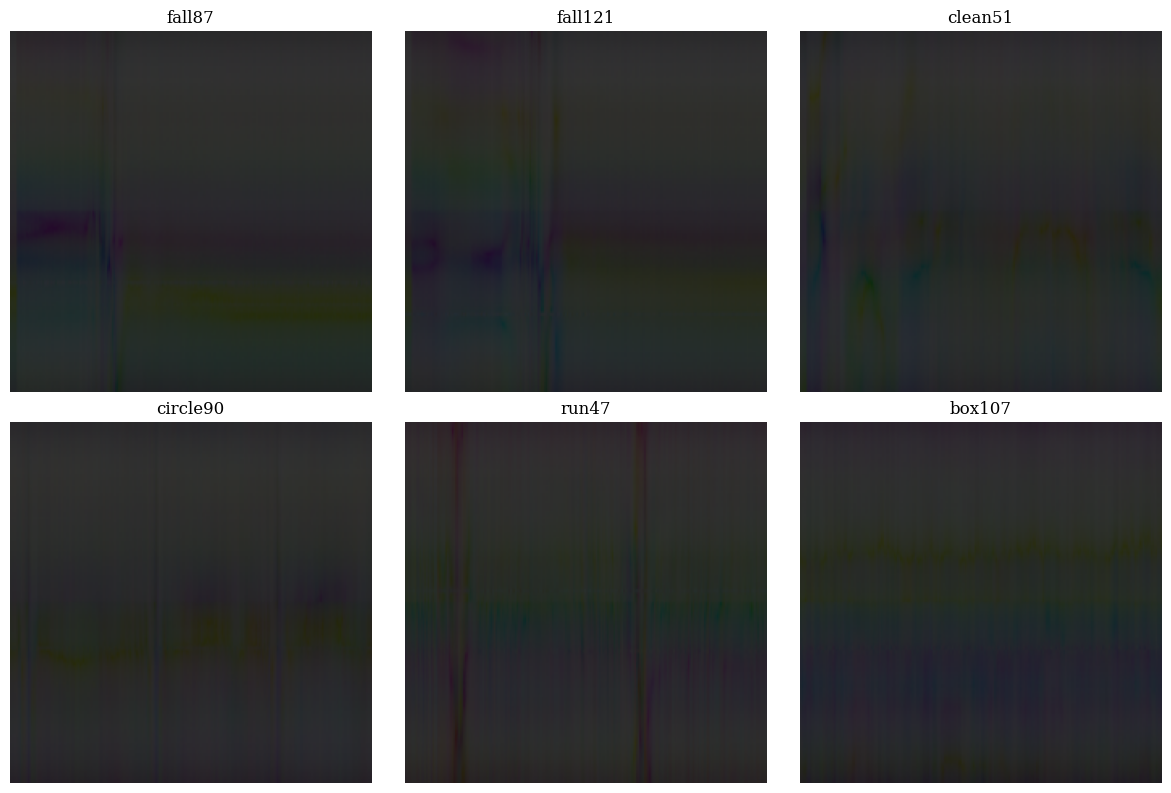

In [24]:
# Define activity labels
labels = ['run', 'walk', 'fall', 'box', 'circle', 'clean']

# Define dataset path (Update if the path is different)
data_dir = Path(data_root_dir+"/human_activity_sensing")

# List all spectrogram files in the directory
csi_filenames = os.listdir(data_dir)

# Number of samples to visualize
num_samples = 6

# Randomly select 'num_samples' files from the dataset
selected_files = sample(csi_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True, sharey=True)

# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    csi_path = data_dir / selected_files[i]
    csi_data = loadmat(csi_path)['CSIamp'].reshape(3, 114, -1).astype(np.uint8)

    # Convert to PIL image (transposing to match image dimensions)
    csi_image = Image.fromarray(np.transpose(csi_data, (1, 2, 0)))

    # Resize image to (224, 224) for better visualization
    csi_resized = csi_image.resize((224, 224), Image.BICUBIC)

    # Display the spectrogram
    ax.imshow(csi_resized, cmap="viridis")  # Use a perceptually uniform colormap
    ax.set_title(selected_files[i].split('.')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for cleaner visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Human Activity Sensing Dataset Class  


In [25]:
class HumanSensingDataset(Dataset):
    """
    A PyTorch Dataset for loading human activity sensing data from CSI (Channel State Information) spectrograms.

    This dataset:
    - Loads CSI amplitude data stored in `.mat` files.
    - Preprocesses data by resizing, normalizing, and applying optional augmentations.
    - Computes dataset-wide normalization statistics.
    - Supports optional downsampling to reduce computational complexity.

    Parameters:
    -----------
    root_dir : str or Path
        Path to the dataset directory containing CSI `.mat` files.
    img_size : tuple, default=(224, 224)
        Target image size for resizing.
    augment_transforms : torchvision.transforms.Compose, optional
        Data augmentation transformations applied to the CSI data.
    downsampled : bool, default=False
        If True, reduces temporal resolution by keeping every 4th frame.
    """

    def __init__(self, root_dir, img_size=(224, 224), augment_transforms=None, downsampled=False):
        self.root_dir = root_dir
        self.file_list = os.listdir(Path(root_dir))  # List of all CSI files in the dataset
        self.img_size = img_size
        self.labels = ['run', 'walk', 'fall', 'box', 'circle', 'clean']  # Activity labels
        self.downsampled = downsampled  # Whether to downsample data
        self.min_val, self.max_val, self.mu, self.std = self.compute_stats()  # Compute normalization stats

        # Define preprocessing transformations
        self.transforms = Compose([
            Lambda(lambda x: torch.as_tensor(x, dtype=torch.float32)),  # Convert to PyTorch tensor
            Resize(self.img_size, antialias=True, interpolation=InterpolationMode.BICUBIC),  # Resize image
            Lambda(lambda x: (x - self.min_val) / (self.max_val - self.min_val)),  # Min-max normalization
            Normalize(self.mu, self.std)  # Apply dataset-wide normalization
        ])

        self.augment_transforms = augment_transforms  # Store optional augmentations

    def compute_stats(self):
        """
        Computes dataset-wide min/max values, mean, and standard deviation for normalization.

        Returns:
        --------
        min_val : float
            Minimum value in the dataset.
        max_val : float
            Maximum value in the dataset.
        mu : torch.Tensor
            Per-channel mean of the dataset.
        std : torch.Tensor
            Per-channel standard deviation of the dataset.
        """
        # Define basic transformations for computing stats
        transforms = Compose([
            Lambda(lambda x: torch.as_tensor(x, dtype=torch.float32)),
            Resize(self.img_size, antialias=True, interpolation=InterpolationMode.BICUBIC)
        ])

        # Initialize min and max values
        min_val, max_val = np.inf, -np.inf

        # First pass: Compute global min and max values
        for sample_name in self.file_list:
            csi = loadmat(os.path.join(self.root_dir, sample_name))['CSIamp'].reshape(3, 114, -1)
            if self.downsampled:
                csi = csi[:, :, ::4]  # Apply downsampling if enabled
            csi = transforms(csi)
            min_val = min(min_val, torch.min(csi).item())
            max_val = max(max_val, torch.max(csi).item())

        # Initialize mean and standard deviation accumulators
        mu, std = torch.zeros((3,)), torch.zeros((3,))

        # Second pass: Compute mean and standard deviation
        for sample_name in self.file_list:
            csi = loadmat(os.path.join(self.root_dir, sample_name))['CSIamp'].reshape(3, 114, -1)
            if self.downsampled:
                csi = csi[:, :, ::4]  # Apply downsampling if enabled
            csi = transforms(csi)
            csi = (csi - min_val) / (max_val - min_val)  # Normalize using computed min-max
            mu += torch.mean(csi, dim=(1, 2))  # Sum per-channel mean
            std += torch.std(csi, dim=(1, 2))  # Sum per-channel std deviation

        # Compute final mean and standard deviation
        mu /= len(self.file_list)
        std /= len(self.file_list)

        return min_val, max_val, mu, std

    @staticmethod
    def _split_at_number(s):
        """
        Extracts the label name from the filename by separating alphabetic and numeric parts.

        Example:
        --------
        Input: 'run12.mat' → Output: 'run'

        Parameters:
        -----------
        s : str
            Filename string.

        Returns:
        --------
        str
            Extracted activity label.
        """
        match = re.match(r"([a-zA-Z]+)(\d+)", s)
        if match:
            return match.groups()[0]  # Return only the alphabetic prefix
        else:
            raise ValueError("Filename format is incorrect. Expected format: '<label><number>.mat'")

    def __getitem__(self, index):
        """
        Loads and preprocesses a CSI sample.

        Parameters:
        -----------
        index : int
            Index of the sample to retrieve.

        Returns:
        --------
        tuple : (torch.Tensor, torch.Tensor)
            CSI spectrogram tensor and its corresponding label index.
        """
        sample_name = self.file_list[index]  # Get filename
        csi = loadmat(os.path.join(self.root_dir, sample_name))['CSIamp']  # Load CSI data
        csi = csi.reshape(3, 114, -1)  # Reshape to (channels, height, width)

        # Apply downsampling if enabled
        if self.downsampled:
            csi = csi[:, :, ::4]

        # Extract class label from filename and convert to index
        label_name = self._split_at_number(sample_name)
        label_index = self.labels.index(label_name)

        # Apply transformations (including optional augmentations)
        if self.augment_transforms:
            csi = self.augment_transforms(self.transforms(csi))
        else:
            csi = self.transforms(csi)

        return csi, torch.as_tensor(label_index, dtype=torch.long)

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
        --------
        int
            Total number of samples.
        """
        return len(self.file_list)

## Fine-Tuning for Human Activity Sensing

Each fine-tuning section includes configurable parameters that you can modify as needed. Some of these settings will directly impact model performance, so choose them carefully.  

---

### **Fine-Tuning Configuration**  
The following configuration parameters define the training setup. You can modify them to experiment with different settings:  

- **`train_test_split`** *(default: `0.8`)* → Proportion of the dataset used for training. A lower value increases validation data.  
- **`batch_size`** *(default: `64`)* → Number of samples per batch. Larger values require more memory but speed up training.  
- **`num_workers`** *(default: `0`)* → Number of subprocesses for data loading. Increase for faster loading if using a powerful CPU.  
- **`frozen_blocks`** *(default: `12`)* → Number of transformer blocks to freeze. Reducing this allows more layers to be fine-tuned.  
- **`lr`** *(default: `1e-2`)* → Initial learning rate. Adjust based on convergence speed and loss stability.  
- **`weight_decay`** *(default: `0.05`)* → Regularization to prevent overfitting. Higher values reduce overfitting but may slow learning.  
- **`layer_decay`** *(default: `0.75`)* → Learning rate decay across layers. Lower values slow weight updates in deeper layers.  
- **`model_size`** *(default: `'small'`)* → Choose `'small'`, `'medium'`, or `'large'`. Larger models improve accuracy but require more resources.  
- **`epochs`** *(default: `50`)* → Total training epochs. Increase for better convergence, but training will take longer.  
- **`warmup_epochs`** *(default: `10`)* → Number of warm-up epochs with a gradually increasing learning rate. Helps stabilize early training.  
- **`output_dir`** *(default: `''`)* → Directory where model checkpoints will be saved. Leave empty to disable saving.  


In [ ]:
# Fixed parameters
task = 'sensing'
task_type = "classification"

# Configurable parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_test_split = 0.8
batch_size = 64
num_workers = 0
frozen_blocks = 12  # Foundation Model Frozen Blocks (1 to 12)
label_smoothing = 0
lr = 1e-2
weight_decay = 0.05
layer_decay = 0.75
model_size = 'small'
epochs = 10
warmup_epochs = 3
output_dir = r"C:\Git_repos\ENDG 511\Lab2\checkpoints\Human"


In [ ]:
def save_parameters():
    param_names = [
        "task", "task_type", "device", "train_test_split", "batch_size",
        "num_workers", "frozen_blocks", "label_smoothing", "lr",
        "weight_decay", "layer_decay", "model_size", "epochs",
        "warmup_epochs", "output_dir"
    ]

    param_strings = ["# Fixed parameters"]
    param_strings.append(f"task = {repr(globals()['task'])}")
    param_strings.append(f"task_type = {repr(globals()['task_type'])}\n")

    param_strings.append("# Configurable parameters")
    for param in param_names[2:]:
        param_strings.append(f"{param} = {repr(globals()[param])}")

    return "\n".join(param_strings)
P = save_parameters()
print(P)

# Fixed parameters
task = 'sensing'
task_type = 'classification'

# Configurable parameters
device = device(type='cpu')
train_test_split = 0.8
batch_size = 64
num_workers = 0
frozen_blocks = 12
label_smoothing = 0
lr = 0.01
weight_decay = 0.05
layer_decay = 0.75
model_size = 'small'
epochs = 10
warmup_epochs = 3
output_dir = 'C:\\Git_repos\\ENDG 511\\Lab2\\checkpoints\\Human'


## Dataset Preparation and Model Initialization

In [ ]:
# Load dataset
dataset = HumanSensingDataset(Path(data_root_dir+r"\human_activity_sensing"))  # Update path if needed

# Set random seed for reproducibility
seed = 42
dataset_train, dataset_val = random_split(dataset, [train_test_split, 1 - train_test_split],
                                          generator=torch.Generator().manual_seed(seed))

# Create dataloaders
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=True, drop_last=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers,
                             pin_memory=True, drop_last=False)

# Initialize Vision Transformer model based on size
if model_size == 'small':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=512, depth=12, num_heads=8,
                              mlp_ratio=4, qkv_bias=True, in_chans=3,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=6)
elif model_size == 'medium':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=768, depth=12, num_heads=12,
                              mlp_ratio=4, qkv_bias=True, in_chans=3,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=6)
elif model_size == 'large':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=1024, depth=24, num_heads=16,
                              mlp_ratio=4, qkv_bias=True, in_chans=3,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=6)
else:
    raise ValueError('Model size must be either small, medium, or large')

## Start Finetuning

In [ ]:
# Load pretrained weights and freeze encoder blocks
checkpoint_path = Path('checkpoints/pretrained_small_75.pth')  # Update if needed
model.load_from_pretrained(checkpoint_path)
model.freeze_encoder(frozen_blocks)
model.to(device)

# Initialize optimizer
param_groups = param_groups_lrd(model, weight_decay, layer_decay=layer_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr)
loss_scaler = NativeScalerWithGradNormCount()

# Display model info
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model}")
print(f"Number of parameters: {n_parameters / 1.e6:.2f}M")
print(f"Base learning rate: {lr * 256 / batch_size:.2e}")
print(f"Actual learning rate: {lr:.2e}")

# Define loss function
criterion = nn.CrossEntropyLoss()
print(f"Criterion: {criterion}")

Model: VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

C:\Users\levis\AppData\Local\Temp\ipykernel_30568\4131671757.py:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()
c:\Users\levis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
print(f"Starting training for {epochs} epochs...")

start_time = time.time()
max_accuracy = 0.0

for epoch in range(epochs):
    # Train for one epoch
    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch,
                                  warmup_epochs, lr, loss_scaler, task_type)

    # Save model checkpoint every 10 epochs
    if output_dir and epoch % 10 == 0:
        model.save_model(os.path.join(output_dir, f'checkpoint-{epoch}.pth'))

    # Evaluate the model
    test_stats = evaluate(data_loader_val, model, criterion, device, task_type)

    # Log accuracy
    print(f"Accuracy on {len(dataset_val)} test samples: {test_stats['acc1']:.3f}%")
    max_accuracy = max(max_accuracy, test_stats["acc1"])
    print(f"Max accuracy so far: {max_accuracy:.3f}%")

# Compute total training time
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Total training time: {total_time_str}")

Starting training for 10 epochs...


C:\Users\levis\AppData\Local\Temp\ipykernel_30568\1375206633.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\levis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch: [0]  [ 0/11]  eta: 0:02:39  lr: 0.000000  loss: 1.7918 (1.7918)  acc1: 3.1250 (3.1250)  acc3: 39.0625 (39.0625)  time: 14.4706  data: 0.8278
Epoch: [0]  [10/11]  eta: 0:00:14  lr: 0.003030  loss: 1.6557 (1.6230)  acc1: 39.0625 (35.0852)  acc3: 76.5625 (70.1705)  time: 14.2532  data: 1.0259
Epoch: [0] Total time: 0:02:36 (14.2579 s / it)
Averaged stats: lr: 0.003030  loss: 1.6557 (1.6230)  acc1: 39.0625 (35.0852)  acc3: 76.5625 (70.1705)
Model successfully saved to C:\Git_repos\ENDG 511\Lab2\checkpoints\Human\checkpoint-0.pth


C:\Users\levis\AppData\Local\Temp\ipykernel_30568\1375206633.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test:  [0/3]  eta: 0:00:23  loss: 1.1729 (1.1729)  acc1: 67.1875 (67.1875)  acc3: 90.6250 (90.6250)  time: 7.9129  data: 1.3991
Test:  [2/3]  eta: 0:00:07  loss: 1.3121 (1.2823)  acc1: 60.9375 (60.9626)  acc3: 89.0625 (85.0267)  time: 7.4317  data: 1.2063
Test: Total time: 0:00:22 (7.4317 s / it)
* Acc@1 60.963 Acc@3 85.027 loss 1.282
Accuracy on 187 test samples: 60.963%
Max accuracy so far: 60.963%
Epoch: [1]  [ 0/11]  eta: 0:02:38  lr: 0.003333  loss: 1.3320 (1.3320)  acc1: 60.9375 (60.9375)  acc3: 84.3750 (84.3750)  time: 14.3846  data: 0.8598
Epoch: [1]  [10/11]  eta: 0:01:38  lr: 0.006364  loss: 0.9257 (0.9499)  acc1: 70.3125 (69.8864)  acc3: 93.7500 (93.6080)  time: 98.0531  data: 1.3013
Epoch: [1] Total time: 0:17:58 (98.0531 s / it)
Averaged stats: lr: 0.006364  loss: 0.9257 (0.9499)  acc1: 70.3125 (69.8864)  acc3: 93.7500 (93.6080)
Test:  [0/3]  eta: 0:00:22  loss: 0.6444 (0.6444)  acc1: 71.8750 (71.8750)  acc3: 100.0000 (100.0000)  time: 7.5531  data: 1.1859
Test:  [2/3]  et

## **Detailed Performance Evaluation**  

Since this is a classification task, we evaluate performance using **confusion matrices**. The provided code will generate the necessary evaluation metrics.

### What is a Confusion Matrix?  

A **confusion matrix** is a table used to evaluate the performance of a classification model. It compares the **true labels** with the **model’s predictions**, showing where the model is correct and where it makes mistakes.  

---

### **Structure of a Confusion Matrix**
Each row represents the **actual class**, and each column represents the **predicted class**.  
A perfect model would have **all values on the diagonal**, meaning no misclassifications.  

### **Example (3-class classification)**  
| Actual \ Predicted | Class A | Class B | Class C |
|--------------------|---------|---------|---------|
| **Class A**       | **50**  |  **5**  | **2**  |
| **Class B**       | **3**   | **40**  | **7**  |
| **Class C**       | **4**   | **6**   | **55**  |

- **Diagonal values (bold)** → Correct predictions.  
- **Off-diagonal values** → Misclassifications.  

---

### **Why Use a Confusion Matrix?**
✅ **Measures Model Performance Beyond Accuracy**  
✅ **Identifies Misclassification Patterns**  
✅ **Highlights Class Imbalance Issues**  
✅ **Helps Optimize Model Performance**  

In this notebook, the confusion matrix is **row-normalized** so each row sums to 1.  This makes it easier to compare error rates across different classes.

---

### **Visualizing the Confusion Matrix**  
We plot a **heatmap**, where:  
- **Darker diagonal = More correct predictions** ✅  
- **Darker off-diagonal = More misclassifications** ❌  

The goal is to **maximize diagonal values** while minimizing off-diagonal errors. A confusion matrix provides deep insights into your model’s classification performance!


 ## **Target Performance Goal:** Achieve **at least 90% validation accuracy**.  


Processing Validation Batches: 100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


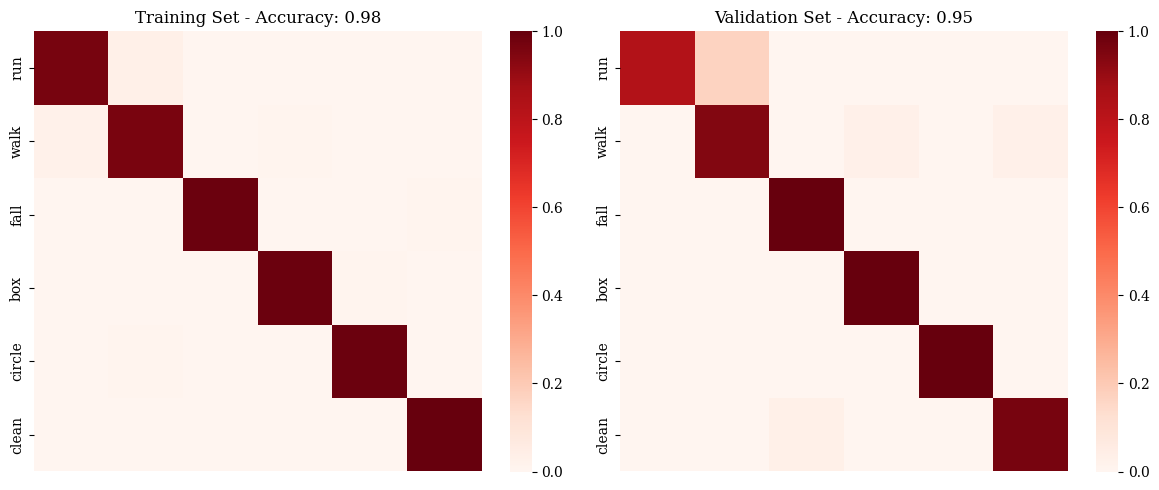

In [ ]:
# Define class names for labeling confusion matrices
class_names = dataset.labels

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets = samples.to(device), targets.to(device)
        output = model(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets = samples.to(device), targets.to(device)
        output = model(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_mat_human_sensing.png'), dpi=400)  # Save figure
plt.show()

# ⚙️ **Fine-Tuning Task 2:** Radio Signal Identification

The dataset for this task consists of spectrograms representing various types of radio signals, categorized into 20 classes. We will begin by visualizing sample spectrograms from the dataset.


## Data Visualization

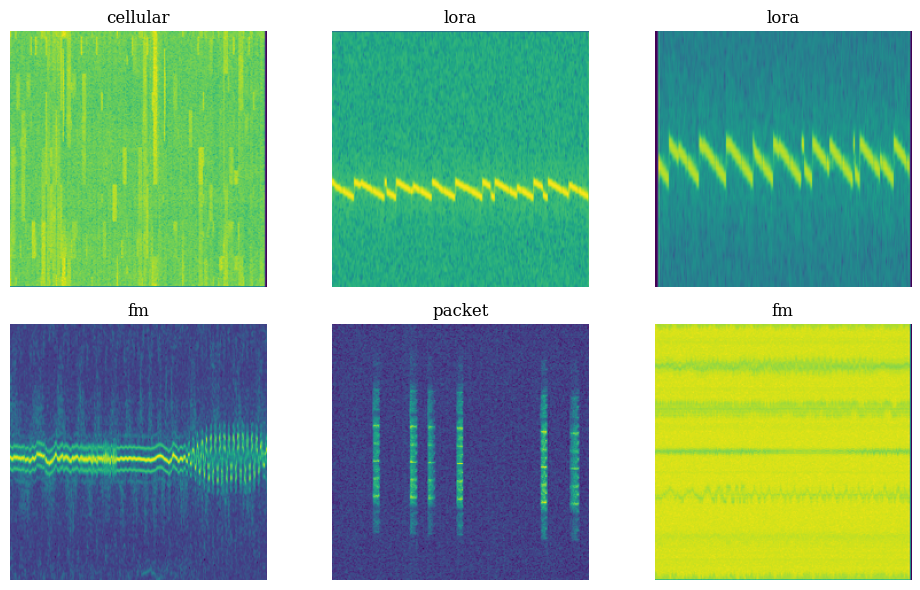

In [10]:
# Define the dataset path (Update if the path is different)

data_dir = Path(data_root_dir+r"/radio_signal_identification_complete/radio_signal_identification")
# List all spectrogram files in the directory
spectrogram_filenames = os.listdir(data_dir)
# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(spectrogram_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    spectrogram_path = os.path.join(data_dir, selected_files[i])
    spectrogram = np.array(Image.open(spectrogram_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    spectrogram = np.squeeze(spectrogram)
    # Display the spectrogram
    ax.imshow(spectrogram, cmap="viridis")  # Ensuring a grayscale colormap
    ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Radio Signal Identification Dataset Class  

In this section, we define a custom PyTorch `RadioSignalDataset` class to efficiently handle data loading.  

PyTorch’s `Dataset` is an abstract class that allows us to create a structured way to load and preprocess data. We will implement a subclass that:  
- Reads and processes the dataset.  
- Applies necessary transformations (e.g., normalization, resizing, grayscale conversion).  
- Returns data samples and their corresponding labels for training and evaluation.  

This dataset class will be used with `torch.utils.data.DataLoader` to enable efficient batch processing and training of the model.

In [31]:
class RadioSignalDataset(Dataset):
    """
    A PyTorch Dataset class for loading and processing spectrogram images of radio signals.

    This dataset:
    - Loads images from a specified directory.
    - Applies preprocessing transformations (grayscale conversion, resizing, normalization).
    - Computes class weights for handling class imbalance.
    - Returns image tensors along with their respective labels.

    Attributes:
    ----------
    data_dir : str
        Path to the dataset directory.
    class_labels : list
        List of signal class names.
    class_weights : torch.Tensor
        Normalized inverse frequency weights for each class.
    data_files : list
        List of all image file names in the dataset.
    transform : torchvision.transforms.Compose
        Transformations applied to each image.
    """

    def __init__(self, data_dir):
        """
        Initializes the dataset by loading class names, computing class frequencies, and setting up transformations.

        Parameters:
        ----------
        data_dir : str
            Path to the dataset directory.
        """
        self.data_dir = data_dir

        # Define class labels (must match the dataset naming convention)
        self.class_labels = [
            'ads-b', 'airband', 'ais', 'automatic-picture-transmission', 'bluetooth', 'cellular',
            'digital-audio-broadcasting', 'digital-speech-decoder', 'fm', 'lora', 'morse', 'on-off-keying', 'packet', 'pocsag', 'Radioteletype', 'remote-keyless-entry', 'RS41-Radiosonde', 'sstv', 'vor', 'wifi'
        ]

        # Get all filenames from the dataset directory

        self.data_files = os.listdir(data_dir)

        # Compute class frequencies (how many samples per class exist)
        class_counts = {label: sum(1 for file in self.data_files if file.startswith(label)) for label in self.class_labels}

        # Compute class weights (inverse frequency) to handle class imbalance
        total_samples = sum(class_counts.values())
        class_weights = [1 / (count / total_samples) if count > 0 else 0 for count in class_counts.values()]

        # Normalize class weights so they sum to 1
        class_weights_sum = sum(class_weights)
        self.class_weights = torch.tensor([w / class_weights_sum for w in class_weights], dtype=torch.float)

        # Define image transformations
        self.transform = Compose([
            ToTensor(),
            Grayscale(),
            Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
            Normalize(mean=[0.5], std=[0.5])
        ])

    def __getitem__(self, index):
        """
        Loads an image, applies transformations, and returns it along with its label index.

        Parameters:
        ----------
        index : int
            Index of the sample in the dataset.

        Returns:
        -------
        tuple(torch.Tensor, torch.Tensor)
            Transformed image tensor and its corresponding label index.
        """
        # Get the filename of the sample
        file_name = self.data_files[index]
        file_path = os.path.join(self.data_dir, file_name)

        # Load the image
        image = Image.open(file_path)

        # Rotate 90 degrees (optional, remove if unnecessary)
        image = image.transpose(Image.ROTATE_90)

        # Ensure the image is in RGB mode (some formats might be grayscale)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Extract the class label from the filename
        class_label = file_name.split('_')[0]
        label_index = self.class_labels.index(class_label)

        # Apply transformations and return image with label
        return self.transform(image), torch.tensor(label_index, dtype=torch.long)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        -------
        int
            Number of files in the dataset.
        """
        return len(self.data_files)


## Fine-Tuning for Radio Signal Identification  

Each fine-tuning section includes configurable parameters that you can modify as needed. Some of these settings will directly impact model performance, so choose them carefully.  

---

### **Fine-Tuning Configuration**  
The following configuration parameters define the training setup. You can modify them to experiment with different settings:  

- **`train_test_split`** *(default: `0.8`)* → Proportion of the dataset used for training. A lower value increases validation data.  
- **`batch_size`** *(default: `64`)* → Number of samples per batch. Larger values require more memory but speed up training.  
- **`num_workers`** *(default: `0`)* → Number of subprocesses for data loading. Increase for faster loading if using a powerful CPU.  
- **`frozen_blocks`** *(default: `12`)* → Number of transformer blocks to freeze. Reducing this allows more layers to be fine-tuned.  
- **`lr`** *(default: `1e-2`)* → Initial learning rate. Adjust based on convergence speed and loss stability.  
- **`weight_decay`** *(default: `0.05`)* → Regularization to prevent overfitting. Higher values reduce overfitting but may slow learning.  
- **`layer_decay`** *(default: `0.75`)* → Learning rate decay across layers. Lower values slow weight updates in deeper layers.  
- **`model_size`** *(default: `'small'`)* → Choose `'small'`, `'medium'`, or `'large'`. Larger models improve accuracy but require more resources.  
- **`epochs`** *(default: `50`)* → Total training epochs. Increase for better convergence, but training will take longer.  
- **`warmup_epochs`** *(default: `10`)* → Number of warm-up epochs with a gradually increasing learning rate. Helps stabilize early training.  
- **`output_dir`** *(default: `''`)* → Directory where model checkpoints will be saved. Leave empty to disable saving.  


In [48]:
# Fixed parameters
task = 'radio_signal_identification'
task_type = "classification"

# Configurable parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_test_split = 0.8
batch_size = 128
num_workers = 0
frozen_blocks = 12  # Foundation Model Frozen Blocks (1 to 12)
label_smoothing = 0
lr = 5e-2
weight_decay = 0.05
layer_decay = 0.75
model_size = 'small'
epochs = 21
warmup_epochs =3
output_dir = cwd +"/checkpoints"

### Fine-tuning Code

### ⚙️ **Subtask 1:**  
Implement a **Stratified Split** instead of the current standard split.

Since this dataset is **imbalanced**, a stratified split ensures that class distributions are preserved in both training and test sets, leading to more reliable model performance.

In [36]:
import sklearn.model_selection
from collections import Counter
import torch
from torch.utils.data import Subset


def stratified_split(dataset, train_test_split_):
    """
    Implement a Stratified Split for an imbalanced dataset.

    Parameters:
    -----------
    dataset : Dataset
        The dataset to split. It must have an attribute `targets` containing class labels.
    train_test_split : float
        The proportion of data to allocate for training.

    Returns:
    --------
    tuple : (train_dataset, test_dataset)
        The stratified training and validation datasets.
    """

    # Extract targets (class labels) from the dataset
    splitter = sklearn.model_selection.StratifiedShuffleSplit(n_splits=2, test_size=(1-train_test_split_), random_state=42)
    dataset_labels_ = []
    for file in dataset.data_files:
      for label in dataset.class_labels:
          if file.startswith(label):
              dataset_labels_.append(label)

    # print(dataset_labels_)
    # Get train and test indices
    train_idx, test_idx = splitter.split(dataset.data_files, dataset_labels_)
    # print(train_idx)


    # Create PyTorch Subset datasets
    print(train_idx[0], train_idx[1])
    train_names = []
    test_names = []
    for i in train_idx:
      train_names.append(dataset.data_files[int(i)])
    test_names = []
    for i in test_idx:
      test_names.append(dataset.data_files[int(i)])

    train_dataset =  Subset(dataset, train_names)
    test_dataset  =  Subset(dataset, test_names)

    return train_dataset, test_dataset


### ⚙️ **Subtask 2: Use Weighted Cross-Entropy Loss**  

Since the dataset is **imbalanced**, using standard cross-entropy loss may cause the model to be biased toward majority classes. To handle this, you need to **use weighted cross-entropy loss**, where class weights adjust the impact of each class based on its frequency.  

#### **Why Use Weighted Loss?**  
- Ensures that underrepresented classes contribute more to the loss, preventing the model from ignoring them.  
- Helps achieve a more balanced performance across all classes.  

#### **What You Need to Do:**  
Modify the loss function by incorporating **class weights** from the dataset. The class weights are already computed and available as `dataset.class_weights`. You need to pass these weights to `torch.nn.CrossEntropyLoss()`.  

#### **Hint:**  
Modify the loss function definition in the fine-tuning code:  

Replace this line:  
```python
criterion = nn.CrossEntropyLoss()
```


## Dataset Preparation and Model Initialization

In [49]:
# Load dataset
dataset = RadioSignalDataset(Path(data_root_dir+r"/radio_signal_identification_complete/radio_signal_identification"))  # Update path if needed

# Set random seed for reproducibility
seed = 42

# ⁉️Replace the line below with your stratified split implementation
dataset_train, dataset_val = random_split(dataset, [train_test_split, 1 - train_test_split],
                                          generator=torch.Generator().manual_seed(seed))


# dataset_train, dataset_val = stratified_split(dataset, train_test_split)

# Create dataloaders
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, pin_memory=True, drop_last=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers,
                             pin_memory=True, drop_last=False)

# Initialize Vision Transformer model based on size
if model_size == 'small':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=512, depth=12, num_heads=8,
                              mlp_ratio=4, qkv_bias=True, in_chans=1,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=20)
elif model_size == 'medium':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=768, depth=12, num_heads=12,
                              mlp_ratio=4, qkv_bias=True, in_chans=1,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=20)
elif model_size == 'large':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=1024, depth=24, num_heads=16,
                              mlp_ratio=4, qkv_bias=True, in_chans=1,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=20)
else:
    raise ValueError('Model size must be either small, medium, or large')

# Load pretrained weights and freeze encoder blocks
checkpoint_path = Path(cwd+'/checkpoints/pretrained_small_75.pth')  # Update if needed
model.load_from_pretrained(checkpoint_path)
model.freeze_encoder(frozen_blocks)
model.to(device)

# Initialize optimizer
param_groups = param_groups_lrd(model, weight_decay, layer_decay=layer_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr)
loss_scaler = NativeScalerWithGradNormCount()

# Display model info
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model}")
print(f"Number of parameters: {n_parameters / 1.e6:.2f}M")
print(f"Base learning rate: {lr * 256 / batch_size:.2e}")
print(f"Actual learning rate: {lr:.2e}")

# Define loss function


# criterion = nn.CrossEntropyLoss(weight=dataset.class_weights)
criterion = nn.CrossEntropyLoss(weight=dataset.class_weights.to(device))

# print(f"Criterion: {criterion}")
# print(f"weights: {dataset.class_weights}")

Model: VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

<ipython-input-7-7ba0b72c56dd>:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


## Start Finetuning

In [50]:
print(f"Starting training for {epochs} epochs...")

start_time = time.time()
max_accuracy = 0.0
test_loss=[]
train_loss=[]
for epoch in range(epochs):
    # Train for one epoch
    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch,
                                  warmup_epochs, lr, loss_scaler, task_type)
    train_loss.append(train_stats['loss'])
    # Save model checkpoint every 10 epochs
    if output_dir and epoch % 10 == 0:
        model.save_model(os.path.join(output_dir, f'checkpoint-{epoch}.pth'))

    # Evaluate the model
    test_stats = evaluate(data_loader_val, model, criterion, device, task_type)
    test_loss.append(test_stats['loss'])


    # Log accuracy
    print(f"Accuracy on {len(dataset_val)} test samples: {test_stats['acc1']:.3f}%")
    max_accuracy = max(max_accuracy, test_stats["acc1"])
    print(f"Max accuracy so far: {max_accuracy:.3f}%")

# Compute total training time
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Total training time: {total_time_str}")

Starting training for 21 epochs...


<ipython-input-8-534faeadefa7>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: [0]  [ 0/18]  eta: 0:08:18  lr: 0.000000  loss: 2.9960 (2.9960)  acc1: 11.7188 (11.7188)  acc3: 23.4375 (23.4375)  time: 27.6885  data: 27.6182  max mem: 6593
Epoch: [0]  [17/18]  eta: 0:00:04  lr: 0.015741  loss: 2.5607 (2.5927)  acc1: 11.7188 (14.7569)  acc3: 28.9062 (33.6806)  time: 4.2346  data: 4.1660  max mem: 6593
Epoch: [0] Total time: 0:01:16 (4.2347 s / it)
Averaged stats: lr: 0.015741  loss: 2.5607 (2.5927)  acc1: 11.7188 (14.7569)  acc3: 28.9062 (33.6806)
Model successfully saved to /content/drive/My Drive/Colab/511_Lab_2/checkpoints/checkpoint-0.pth


<ipython-input-8-534faeadefa7>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test:  [0/5]  eta: 0:00:15  loss: 2.5896 (2.5896)  acc1: 24.2188 (24.2188)  acc3: 53.9062 (53.9062)  time: 3.0948  data: 3.0670  max mem: 6593
Test:  [4/5]  eta: 0:00:02  loss: 2.6972 (2.6017)  acc1: 24.2188 (22.8374)  acc3: 56.2500 (57.2664)  time: 2.6228  data: 2.5970  max mem: 6593
Test: Total time: 0:00:13 (2.6231 s / it)
* Acc@1 22.837 Acc@3 57.266 loss 2.602
Accuracy on 578 test samples: 22.837%
Max accuracy so far: 22.837%
Epoch: [1]  [ 0/18]  eta: 0:00:51  lr: 0.016667  loss: 3.0695 (3.0695)  acc1: 23.4375 (23.4375)  acc3: 60.9375 (60.9375)  time: 2.8661  data: 2.7977  max mem: 6593
Epoch: [1]  [17/18]  eta: 0:00:02  lr: 0.032407  loss: 1.9047 (2.0936)  acc1: 28.1250 (29.7743)  acc3: 54.6875 (55.8594)  time: 2.8608  data: 2.7923  max mem: 6593
Epoch: [1] Total time: 0:00:51 (2.8609 s / it)
Averaged stats: lr: 0.032407  loss: 1.9047 (2.0936)  acc1: 28.1250 (29.7743)  acc3: 54.6875 (55.8594)
Test:  [0/5]  eta: 0:00:13  loss: 1.7495 (1.7495)  acc1: 42.9688 (42.9688)  acc3: 71.0938

### ⚙️ **Subtask 3: Detailed Performance Evaluation**  

Since this is a **classification task**, we will assess model performance using **confusion matrices**.  

**What to Do:**  
Use the evaluation code from the **Human Activity Sensing** task as a reference to implement the **evaluation** for this task.  

**Hint:**  
You can retrieve class names from the `RadioSignalDataset` class using:  
```python
class_names = dataset.labels
```

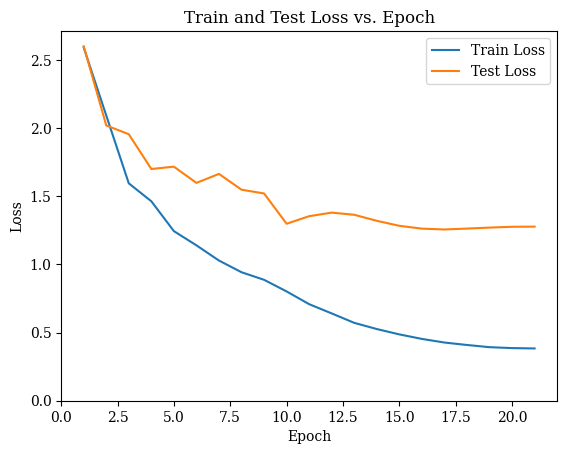

In [53]:
# prompt: plot train_loss and test_loss vs epoch
N = 0

# Assuming train_loss and test_loss are lists containing the loss values for each epoch
plt.plot(range(1+N, len(train_loss) + 1), train_loss[N:], label='Train Loss')
plt.plot(range(1+N, len(test_loss) + 1), test_loss[N:], label='Test Loss')
bottom, top = plt.ylim()  # return the current ylim
plt.ylim(0, top)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs. Epoch')
plt.legend()
plt.show()

## **Target Performance Goal:** Achieve at least 80% validation accuracy.  

**Experiment with configuration parameters** (e.g., learning rate, batch size, frozen layers) to optimize performance.


Processing Validation Batches: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


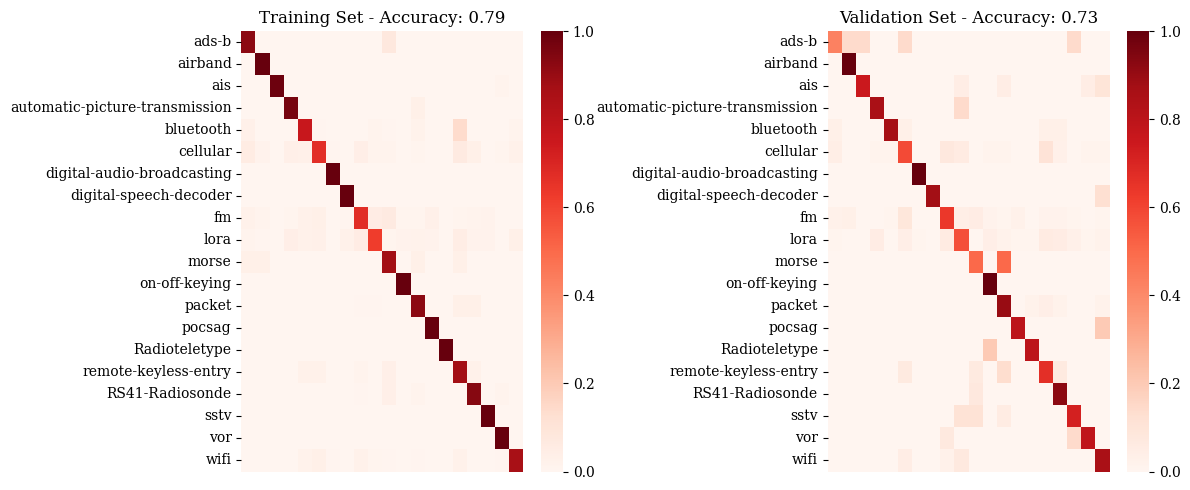

In [54]:
# Define class names for labeling confusion matrices
class_names = dataset.class_labels

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets = samples.to(device), targets.to(device)
        output = model(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets = samples.to(device), targets.to(device)
        output = model(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(conf_mat_val)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_mat_radio.png'), dpi=400)  # Save figure
plt.show()

# ⚙️ **Fine-Tuning Task 3:** 5G CSI-Based Positioning Task  

This dataset contains **CSI measurements** from 5G **sounding reference signals** exchanged between a user device (UE) and four **4×4 MIMO base stations**. The task is to predict the UE's position based on its CSI.

![Positioning](https://drive.google.com/uc?export=view&id=1_7HR_BnN0FxL8o0sBlSq3Oe4vrdYc4xo)

**Source:** K. Gao, H. Wang, H. Lv and W. Liu, "Toward 5G NR High-Precision Indoor Positioning via Channel Frequency Response: A New Paradigm and Dataset Generation Method," in IEEE Journal on Selected Areas in Communications, vol. 40, no. 7, pp. 2233-2247, July 2022, doi: 10.1109/JSAC.2022.3157397

## Data Visualization

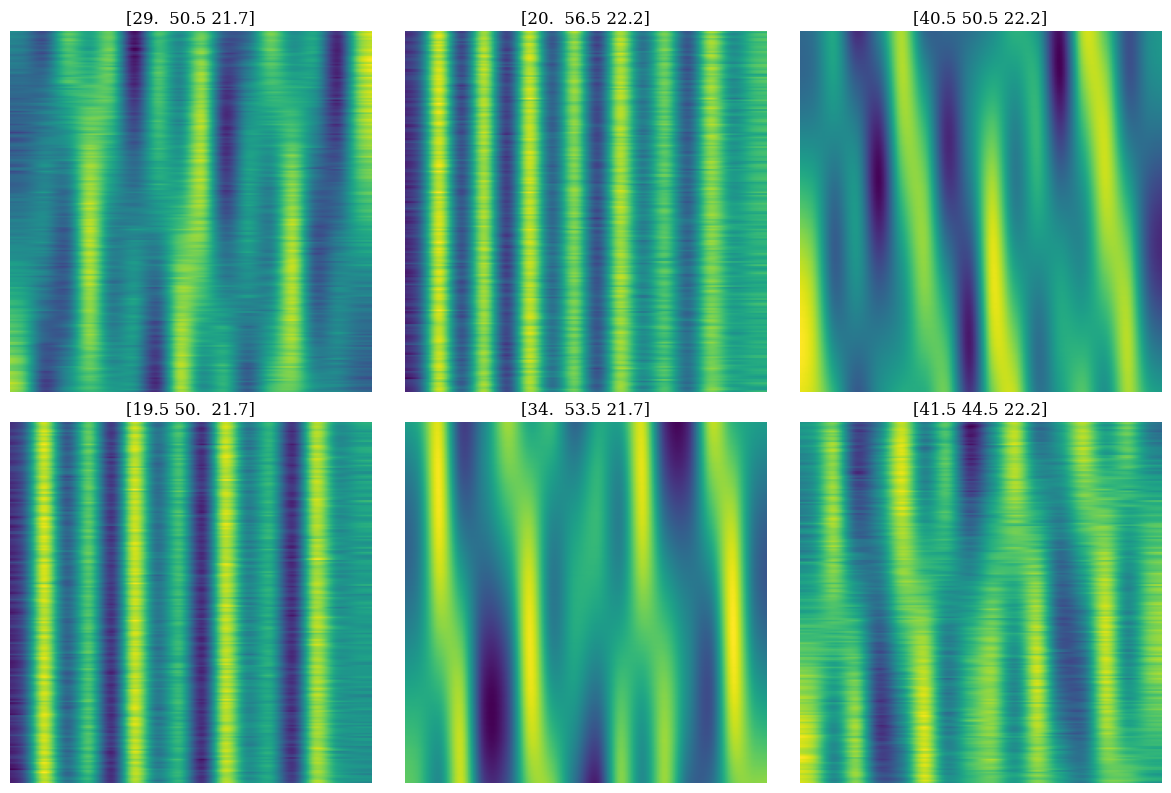

In [9]:
# Define dataset path (Update if the path is different)
data_dir5g = Path(data_root_dir+r"/5g_positioning")

# List all spectrogram files in the directory
csi_filenames = os.listdir(data_dir5g)

# Number of samples to visualize
num_samples = 6

# Randomly select 'num_samples' files from the dataset
selected_files = sample(csi_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True, sharey=True)

# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    sample_path = data_dir5g / selected_files[i]
    with h5py.File(sample_path, 'r') as sample_file:
        features = np.array(sample_file['features'])
        position = np.array(sample_file['position'])

    # Convert to PIL image (transposing to match image dimensions)
    csi_image = Image.fromarray(features[0].T)

    # Resize image to (224, 224) for better visualization
    csi_resized = np.array(csi_image.resize((224, 224), Image.BICUBIC))

    # Display the spectrogram
    ax.imshow(csi_resized, cmap="viridis")  # Use a perceptually uniform colormap
    ax.set_title(position)  # Extract class label from filename
    ax.axis("off")  # Hide axes for cleaner visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## 5G Positioning Dataset Class  


In [108]:
class Positioning5G(Dataset):
    """
    A PyTorch Dataset for 5G NR-based positioning.

    This dataset:
    - Loads CSI (Channel State Information) features from `.h5` files.
    - Normalizes and transforms features for model training.
    - Converts position labels to a normalized range [-1, 1].
    - Supports both 'outdoor' and 'indoor' positioning scenarios.

    Parameters:
    ----------
    datapath : str or Path
        Path to the dataset directory containing `.h5` files.
    img_size : tuple, default=(224, 224)
        Target image size for resizing.
    scene : str, default='outdoor'
        Specifies whether to load 'outdoor' or 'indoor' scene data.

    Raises:
    -------
    ValueError
        If the specified scene is not recognized.
    """

    def __init__(self, datapath, img_size=(224, 224), scene='outdoor'):
        self.img_size = img_size
        self.scene = scene

        # Get list of all `.h5` files for the specified scene
        self.data_files = [os.path.join(datapath, filename) for filename in os.listdir(datapath)
        ]
        self.num_samples = len(self.data_files)

        # Define scene-specific normalization parameters
        if scene == 'outdoor':
            self.min_val, self.max_val = -0.096, 1.136
            self.mu = torch.as_tensor([0.4638, 0.4631, 0.4703, 0.4620])
            self.std = torch.as_tensor([0.1154, 0.1176, 0.0979, 0.1281])
            self.coord_nominal_min = torch.as_tensor([0, 0, 0], dtype=torch.float32)
            self.coord_nominal_max = torch.as_tensor([80, 60, 40], dtype=torch.float32)

        elif scene == 'indoor':
            self.min_val, self.max_val = -0.123, 1.415
            self.mu = torch.as_tensor([0.3824, 0.3853, 0.3841, 0.3931, 0.3909])
            self.std = torch.as_tensor([0.1168, 0.1112, 0.1182, 0.0988, 0.0972])
            self.coord_nominal_min = torch.as_tensor([0, 0, 0], dtype=torch.float32)
            self.coord_nominal_max = torch.as_tensor([60, 20, 4], dtype=torch.float32)

        else:
            raise ValueError("Scene not recognized. Choose either 'outdoor' or 'indoor'.")

        # Define transformations for feature preprocessing
        self.transforms = Compose([
            Lambda(lambda x: torch.as_tensor(x, dtype=torch.float32)),  # Convert to PyTorch tensor
            Resize(self.img_size, antialias=True, interpolation=InterpolationMode.BICUBIC),  # Resize feature maps
            Lambda(lambda x: (x - self.min_val) / (self.max_val - self.min_val)),  # Min-max normalization
            Normalize(self.mu, self.std)  # Standardization
        ])

    def __getitem__(self, index):
        """
        Loads and preprocesses a sample.

        Parameters:
        ----------
        index : int
            Index of the sample to retrieve.

        Returns:
        -------
        tuple : (torch.Tensor, torch.Tensor)
            Processed CSI feature tensor and normalized position label.
        """
        # Load features and labels from an `.h5` file
        with h5py.File(self.data_files[index], 'r') as data_file:
            features = np.array(data_file['features'])  # CSI feature map
            labels = torch.as_tensor(np.array(data_file['position']), dtype=torch.float)  # Position label

        # Normalize position labels to range [-1, 1]
        labels = 2 * (labels - self.coord_nominal_min) / (self.coord_nominal_max - self.coord_nominal_min) - 1

        # Apply transformations to features
        features = self.transforms(features)

        return features, labels

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        -------
        int
            Total number of samples.
        """
        return self.num_samples

## Fine-Tuning for 5G Positioning

Each fine-tuning section includes configurable parameters that you can modify as needed. Some of these settings will directly impact model performance, so choose them carefully.  

---

### **Fine-Tuning Configuration**  
The following configuration parameters define the training setup. You can modify them to experiment with different settings:  

- **`train_test_split`** *(default: `0.8`)* → Proportion of the dataset used for training. A lower value increases validation data.  
- **`batch_size`** *(default: `64`)* → Number of samples per batch. Larger values require more memory but speed up training.  
- **`num_workers`** *(default: `0`)* → Number of subprocesses for data loading. Increase for faster loading if using a powerful CPU.  
- **`frozen_blocks`** *(default: `12`)* → Number of transformer blocks to freeze. Reducing this allows more layers to be fine-tuned.  
- **`lr`** *(default: `1e-2`)* → Initial learning rate. Adjust based on convergence speed and loss stability.  
- **`weight_decay`** *(default: `0.05`)* → Regularization to prevent overfitting. Higher values reduce overfitting but may slow learning.  
- **`layer_decay`** *(default: `0.75`)* → Learning rate decay across layers. Lower values slow weight updates in deeper layers.  
- **`model_size`** *(default: `'small'`)* → Choose `'small'`, `'medium'`, or `'large'`. Larger models improve accuracy but require more resources.  
- **`epochs`** *(default: `50`)* → Total training epochs. Increase for better convergence, but training will take longer.  
- **`warmup_epochs`** *(default: `10`)* → Number of warm-up epochs with a gradually increasing learning rate. Helps stabilize early training.  
- **`output_dir`** *(default: `''`)* → Directory where model checkpoints will be saved. Leave empty to disable saving.  


In [119]:
# Fixed parameters
task = 'positioning'
task_type = "regression"

# Configurable parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_test_split = 0.8
batch_size = 128
num_workers = 8####
frozen_blocks = 5  # Foundation Model Frozen Blocks (1 to 12)
label_smoothing = 0
lr = 2e-4
weight_decay = 0.8
layer_decay = 0.75
model_size = 'small'
epochs = 51
warmup_epochs = 7
output_dir = cwd+r'/checkpoints/pos_5g'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Dataset Preparation and Model Initialization

In [120]:
# Load dataset
data_dir5g = data_root_dir+r"/5g_positioning"
print(data_dir5g)
dataset = Positioning5G(Path(data_dir5g))  # Update path if needed
checkpoint_path = Path(cwd+r'/checkpoints/pretrained_small_75.pth')  # Update if


# Set random seed for reproducibility
seed = 42
dataset_train, dataset_val = random_split(dataset, [train_test_split, 1 - train_test_split],
                                          generator=torch.Generator().manual_seed(seed))

# Create dataloaders
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=True, drop_last=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers,
                             pin_memory=True, drop_last=False)

# Initialize Vision Transformer model based on size
if model_size == 'small':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=512, depth=12, num_heads=8,
                              mlp_ratio=4, qkv_bias=True, in_chans=4,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=3, tanh=True)
elif model_size == 'medium':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=768, depth=12, num_heads=12,
                              mlp_ratio=4, qkv_bias=True, in_chans=4,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=3, tanh=True)
elif model_size == 'large':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=1024, depth=24, num_heads=16,
                              mlp_ratio=4, qkv_bias=True, in_chans=4,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=3, tanh=True)
else:
    raise ValueError('Model size must be either small, medium, or large')

# Load pretrained weights and freeze encoder blocks


model.load_from_pretrained(checkpoint_path)
model.freeze_encoder(frozen_blocks)
model.to(device)

# Initialize optimizer
param_groups = param_groups_lrd(model, weight_decay, layer_decay=layer_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr)
loss_scaler = NativeScalerWithGradNormCount()

# Display model info
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model}")
print(f"Number of parameters: {n_parameters / 1.e6:.2f}M")
print(f"Base learning rate: {lr * 256 / batch_size:.2e}")
print(f"Actual learning rate: {lr:.2e}")

# Define loss function
criterion = nn.MSELoss()
print(f"Criterion: {criterion}")

/content/drive/My Drive/Colab/511_Lab_2/Data/RFM Lab Data/5g_positioning
Model: VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(4, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate=

<ipython-input-7-7ba0b72c56dd>:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


## Start Finetuning

In [ ]:
# load_state = model.load_model(r'C:\Git_repos\ENDG 511\511_lab2\checkpoints\pos_5g_dk\checkpoint-b-0.pth')
# param_groups = param_groups_lrd(model, weight_decay, layer_decay=layer_decay)
# optimizer = torch.optim.AdamW(param_groups, lr=lr)
# print(load_state)

<All keys matched successfully>


In [ ]:
print(f"Starting training for {epochs} epochs...")
start_time = time.time()
max_accuracy = 0.0
min_error = math.inf
test_loss = []
train_loss = []
for epoch in range(epochs):
    # Train for one epoch
    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch,
                                  warmup_epochs, lr, loss_scaler, task_type)
    train_loss.append(train_stats['loss'])

    # Ev
    # Save model checkpoint every 10 epochs
    if output_dir and epoch % 10 == 0:
        model.save_model(os.path.join(output_dir, f'checkpoint-F7-{epoch}.pth'))

    # Evaluate the model
    test_stats = evaluate(data_loader_val, model, criterion, device, task_type)
    test_loss.append(test_stats['loss'])
    # Log accuracy
    print(f"Error on {len(dataset_val)} test samples: {test_stats['loss']:.3f}%")
    min_error = min(min_error, test_stats["loss"])
    print(f"Min error so far: {min_error:.3f}")

# Compute total training time
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Total training time: {total_time_str}")

Starting training for 51 epochs...


<ipython-input-8-534faeadefa7>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: [0]  [ 0/41]  eta: 0:07:50  lr: 0.000000  loss: 0.2191 (0.2191)  time: 11.4655  data: 11.2531  max mem: 19853
Epoch: [0]  [20/41]  eta: 0:00:15  lr: 0.000014  loss: 0.2065 (0.2072)  time: 0.2194  data: 0.1374  max mem: 20024
Epoch: [0]  [40/41]  eta: 0:00:00  lr: 0.000028  loss: 0.1508 (0.1801)  time: 0.2420  data: 0.1579  max mem: 20024
Epoch: [0] Total time: 0:00:20 (0.5071 s / it)
Averaged stats: lr: 0.000028  loss: 0.1508 (0.1801)
Model successfully saved to /content/drive/My Drive/Colab/511_Lab_2/checkpoints/pos_5g/checkpoint-F7-0.pth


<ipython-input-8-534faeadefa7>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test:  [ 0/11]  eta: 0:00:27  loss: 0.1103 (0.1103)  time: 2.4956  data: 2.4608  max mem: 20024
Test:  [10/11]  eta: 0:00:00  loss: 0.1054 (0.1055)  time: 0.3496  data: 0.3190  max mem: 20024
Test: Total time: 0:00:03 (0.3577 s / it)
* Loss 0.105
Error on 1327 test samples: 0.105%
Min error so far: 0.105
Epoch: [1]  [ 0/41]  eta: 0:01:46  lr: 0.000029  loss: 0.1081 (0.1081)  time: 2.6017  data: 2.5043  max mem: 20024
Epoch: [1]  [20/41]  eta: 0:00:07  lr: 0.000043  loss: 0.0606 (0.0687)  time: 0.2493  data: 0.1669  max mem: 20024
Epoch: [1]  [40/41]  eta: 0:00:00  lr: 0.000056  loss: 0.0278 (0.0492)  time: 0.2425  data: 0.1617  max mem: 20024
Epoch: [1] Total time: 0:00:12 (0.3055 s / it)
Averaged stats: lr: 0.000056  loss: 0.0278 (0.0492)
Test:  [ 0/11]  eta: 0:00:30  loss: 0.0225 (0.0225)  time: 2.7313  data: 2.6964  max mem: 20024
Test:  [10/11]  eta: 0:00:00  loss: 0.0220 (0.0223)  time: 0.3418  data: 0.3109  max mem: 20024
Test: Total time: 0:00:03 (0.3499 s / it)
* Loss 0.022
Err

## **Detailed Performance Evaluation**  

Since this is a **regression task**, we evaluate model performance using **Mean Squared Error (MSE) for positioning**.  

**What This Code Does:**  
- Computes the **positioning error** by comparing predicted positions to ground truth values.  
- Uses **Mean Squared Error (MSE)** as the primary metric.  
- Plots a **histogram** to visualize the **distribution of errors** across the dataset.  

**Why is this important?**  
- A well-performing model should have **lower error values** concentrated near zero.  
- The histogram helps identify **outliers** and **patterns in prediction errors**.  

## Run the code below to analyze your model’s performance!
## **Target Performance Goal:** Achieve a mean positioning error of ≤ 2 meters.



Processing Test Batches: 100%|██████████| 21/21 [00:07<00:00,  2.63it/s]


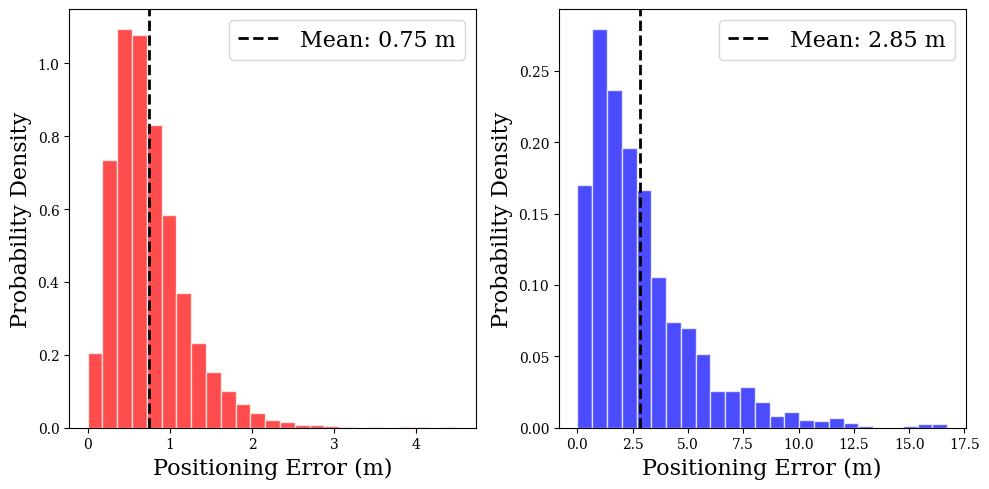

In [24]:
def reverse_normalize(x, coord_min, coord_max):
    """
    Reverse the normalization applied to coordinates.

    Parameters:
    ----------
    x : torch.Tensor
        Normalized coordinates in the range [-1, 1].
    coord_min : torch.Tensor
        Minimum coordinate values.
    coord_max : torch.Tensor
        Maximum coordinate values.

    Returns:
    -------
    torch.Tensor
        Denormalized coordinates in the original range.
    """
    return (x + 1) / 2 * (coord_max - coord_min) + coord_min

# Retrieve coordinate normalization bounds
coord_min = dataset.coord_nominal_min
coord_max = dataset.coord_nominal_max

# Move model to device
model = model.to(device)

# ------------------------
# 📌 Compute Positioning Errors for Training Data
# ------------------------
distances_train = torch.zeros(len(dataset_train))

with torch.no_grad():
    for i, batch in tqdm(enumerate(data_loader_train), desc="Processing Train Batches", total=len(data_loader_train)):
        images, targets = batch
        images = images.to(device)

        # Predict positions and reverse normalization
        pred_positions = reverse_normalize(model(images).cpu(), coord_min, coord_max)
        true_positions = reverse_normalize(targets.cpu(), coord_min, coord_max)

        num_samples = targets.shape[0]
        start_idx, end_idx = i * num_samples, (i + 1) * num_samples

        # Compute Euclidean distance between predicted and actual positions
        distances_train[start_idx:end_idx] = torch.sqrt(torch.sum((pred_positions - true_positions) ** 2, dim=1))

# ------------------------
# 📌 Compute Positioning Errors for Test Data
# ------------------------
distances_test = torch.zeros(len(dataset_val))

with torch.no_grad():
    for i, batch in tqdm(enumerate(data_loader_val), desc="Processing Test Batches", total=len(data_loader_val)):
        images, targets = batch
        images = images.to(device)

        # Predict positions and reverse normalization
        pred_positions = reverse_normalize(model(images).cpu(), coord_min, coord_max)
        true_positions = reverse_normalize(targets.cpu(), coord_min, coord_max)

        num_samples = targets.shape[0]
        start_idx, end_idx = i * num_samples, (i + 1) * num_samples

        # Compute Euclidean distance between predicted and actual positions
        distances_test[start_idx:end_idx] = torch.sqrt(torch.sum((pred_positions - true_positions) ** 2, dim=1))

# Convert to NumPy arrays for visualization
distances_train = distances_train.numpy()
distances_test = distances_test.numpy()

# ------------------------
# 📌 Plot Positioning Error Distributions
# ------------------------
plt.rcParams["font.family"] = "serif"

# Compute mean errors
mean_train = np.mean(distances_train)
mean_test = np.mean(distances_test)

# Set up histogram plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
bins = 25

# Training Error Histogram
axs[0].hist(distances_train, bins=bins, color="red", edgecolor="w", alpha=0.7, density=True)
axs[0].axvline(mean_train, color="black", linestyle="--", linewidth=2, label=f"Mean: {mean_train:.2f} m")
axs[0].set_xlabel("Positioning Error (m)", fontsize=16)
axs[0].set_ylabel("Probability Density", fontsize=16)
axs[0].legend(fontsize=16)

# Test Error Histogram
axs[1].hist(distances_test, bins=bins, color="blue", edgecolor="w", alpha=0.7, density=True)
axs[1].axvline(mean_test, color="black", linestyle="--", linewidth=2, label=f"Mean: {mean_test:.2f} m")
axs[1].set_xlabel("Positioning Error (m)", fontsize=16)
axs[1].set_ylabel("Probability Density", fontsize=16)
axs[1].legend(fontsize=16)

# Final layout and save
plt.tight_layout()
plt.savefig("hist_positioning.png", dpi=300)
plt.show()

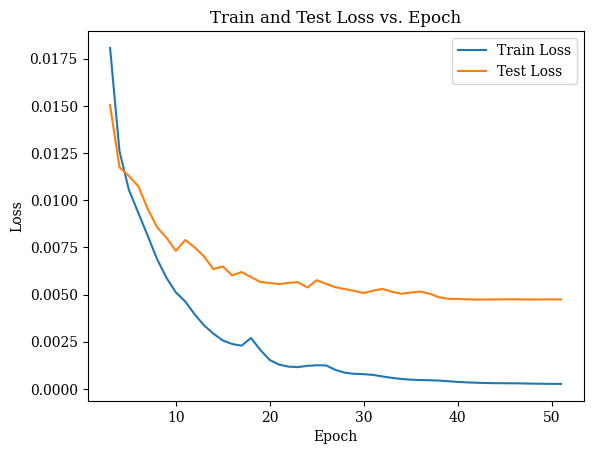

In [28]:
# prompt: plot train_loss and test_loss vs epoch
N = 2

# Assuming train_loss and test_loss are lists containing the loss values for each epoch
plt.plot(range(1+N, len(train_loss) + 1), train_loss[N:], label='Train Loss')
plt.plot(range(1+N, len(test_loss) + 1), test_loss[N:], label='Test Loss')
bottom, top = plt.ylim()  # return the current ylim
plt.ylim(0, top)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs. Epoch')
plt.legend()
plt.show()


# ⚙️ **Fine-Tuning Task 4: Enhance the Regression Head & Fine-Tune for Positioning**

The current model uses a **single-layer regression head**. Your task is to **replace it with a multi-layer head** that includes **nonlinear activations**. This can improve the model’s ability to learn complex positional relationships.

#### **What to Do**

1. **Modify the `VisionTransformer` class by subclassing it** or by introducing parameters to control your task head.
2. Replace `self.head` with a **multi-layer MLP head** that includes:
   - **Fully connected layers**
   - **Nonlinear activations** (e.g., ReLU, GELU)
   - **Dropout (optional, but recommended)**
3. **Fine-tune the model only for the 5G Positioning task** using the best hyperparameter setup identified earlier.

#### **Hints**

- Modify `__init__()` to define a multi-layer MLP head using `torch.nn.Sequential()`.
- Another approach is to **modify `VisionTransformer`** and introduce parameters that allow controlling the task-specific head dynamically.
- The **final layer should match the number of outputs** (`3` for 5G Positioning).
- Experiment with different activation functions and dropout rates to enhance generalization.

#### **Where to Implement It**

Use the following code cell to implement your solution.


In [96]:
# Implement Your Multi-Layer Head

# Option 1: Subclass VisionTransformer and Modify `self.head`
class VisionTransformerWithMLPHead(VisionTransformer):
    def __init__(self, task: str, global_pool: str = "token", tanh: bool = False, num_classes: int = 6, **kwargs):
        super().__init__(task=task, global_pool=global_pool, tanh=tanh, **kwargs)

        # 🔹 Replace the single-layer head with a multi-layer MLP head
        self.head = nn.Linear(self.embed_dim, num_classes)

        self.activation = nn.ReLU()
        self.head_dropout = 0.05

        self.head = nn.Sequential(
            nn.Linear(self.embed_dim, 256),  # First layer
            self.activation,
            nn.Dropout(self.head_dropout),  # Dropout layer
            nn.Linear(256, 64),  # Second layer
            self.activation,
            nn.Dropout(self.head_dropout),
            nn.Linear(64, num_classes)  # Final layer (3 outputs for 5G Positioning)
        )

# Option 2: Modify the VisionTransformer Class
# Instead of subclassing, add a parameter (e.g., `head_layers`) to control `self.head`
# This allows flexible configuration while keeping the original class intact.


In [114]:
# Fixed parameters
task = 'positioning'
task_type = "regression"

# Configurable parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_test_split = 0.8
batch_size = 256
num_workers = 4####
frozen_blocks = 10  # Foundation Model Frozen Blocks (1 to 12)
label_smoothing = 0
lr = 5e-4
weight_decay = 0.2
layer_decay = 0.75
model_size = 'small'
epochs = 51
warmup_epochs = 7
output_dir = cwd+r'/checkpoints/pos_5g'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## load dataset

In [115]:
# Load dataset
data_dir5g = data_root_dir+r"/5g_positioning"
print(data_dir5g)
dataset = Positioning5G(Path(data_dir5g))  # Update path if needed
checkpoint_path = Path(cwd+r'/checkpoints/pretrained_small_75.pth')  # Update if


# Set random seed for reproducibility
seed = 42
dataset_train, dataset_val = random_split(dataset, [train_test_split, 1 - train_test_split],
                                          generator=torch.Generator().manual_seed(seed))

# Create dataloaders
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=True, drop_last=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers,
                             pin_memory=True, drop_last=False)

# Initialize Vision Transformer model based on size
if model_size == 'small':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=512, depth=12, num_heads=8,
                              mlp_ratio=4, qkv_bias=True, in_chans=4,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=3, tanh=True)
elif model_size == 'medium':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=768, depth=12, num_heads=12,
                              mlp_ratio=4, qkv_bias=True, in_chans=4,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=3, tanh=True)
elif model_size == 'large':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=1024, depth=24, num_heads=16,
                              mlp_ratio=4, qkv_bias=True, in_chans=4,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=3, tanh=True)
else:
    raise ValueError('Model size must be either small, medium, or large')

# Load pretrained weights and freeze encoder blocks


model.load_from_pretrained(checkpoint_path)
model.freeze_encoder(frozen_blocks)
model.to(device)

# Initialize optimizer
param_groups = param_groups_lrd(model, weight_decay, layer_decay=layer_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr)
loss_scaler = NativeScalerWithGradNormCount()

# Display model info
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model}")
print(f"Number of parameters: {n_parameters / 1.e6:.2f}M")
print(f"Base learning rate: {lr * 256 / batch_size:.2e}")
print(f"Actual learning rate: {lr:.2e}")

# Define loss function
criterion = nn.MSELoss()
print(f"Criterion: {criterion}")

/content/drive/My Drive/Colab/511_Lab_2/Data/RFM Lab Data/5g_positioning
Model: VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(4, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate=

<ipython-input-7-7ba0b72c56dd>:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


In [118]:
print(weight_decay)

0.2


## train model

In [116]:
print(f"Starting training for {epochs} epochs...")
start_time = time.time()
max_accuracy = 0.0
min_error = math.inf
test_loss = []
train_loss = []
for epoch in range(epochs):
    # Train for one epoch
    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch,
                                  warmup_epochs, lr, loss_scaler, task_type)
    train_loss.append(train_stats['loss'])

    # Ev
    # Save model checkpoint every 10 epochs
    if output_dir and epoch % 10 == 0:
        model.save_model(os.path.join(output_dir, f'checkpoint-customH2-{epoch}.pth'))

    # Evaluate the model
    test_stats = evaluate(data_loader_val, model, criterion, device, task_type)
    test_loss.append(test_stats['loss'])
    # Log accuracy
    print(f"Error on {len(dataset_val)} test samples: {test_stats['loss']:.3f}%")
    min_error = min(min_error, test_stats["loss"])
    print(f"Min error so far: {min_error:.3f}")

# Compute total training time
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Total training time: {total_time_str}")

Starting training for 51 epochs...


<ipython-input-8-534faeadefa7>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: [0]  [ 0/20]  eta: 0:22:13  lr: 0.000000  loss: 0.2150 (0.2150)  time: 66.6717  data: 66.5212  max mem: 16958
Epoch: [0]  [19/20]  eta: 0:00:03  lr: 0.000068  loss: 0.1865 (0.1780)  time: 3.8408  data: 3.7045  max mem: 16999
Epoch: [0] Total time: 0:01:16 (3.8437 s / it)
Averaged stats: lr: 0.000068  loss: 0.1865 (0.1780)
Model successfully saved to /content/drive/My Drive/Colab/511_Lab_2/checkpoints/pos_5g/checkpoint-customH2-0.pth


<ipython-input-8-534faeadefa7>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test:  [0/6]  eta: 0:00:18  loss: 0.1024 (0.1024)  time: 3.0076  data: 2.9412  max mem: 16999
Test:  [5/6]  eta: 0:00:00  loss: 0.0993 (0.0984)  time: 0.7248  data: 0.6693  max mem: 16999
Test: Total time: 0:00:04 (0.7372 s / it)
* Loss 0.098
Error on 1327 test samples: 0.098%
Min error so far: 0.098
Epoch: [1]  [ 0/20]  eta: 0:01:00  lr: 0.000071  loss: 0.0989 (0.0989)  time: 3.0401  data: 2.8891  max mem: 16999
Epoch: [1]  [19/20]  eta: 0:00:00  lr: 0.000139  loss: 0.0381 (0.0465)  time: 0.6842  data: 0.5465  max mem: 16999
Epoch: [1] Total time: 0:00:13 (0.6872 s / it)
Averaged stats: lr: 0.000139  loss: 0.0381 (0.0465)
Test:  [0/6]  eta: 0:00:17  loss: 0.0237 (0.0237)  time: 2.9686  data: 2.9023  max mem: 16999
Test:  [5/6]  eta: 0:00:00  loss: 0.0221 (0.0225)  time: 0.7123  data: 0.6572  max mem: 16999
Test: Total time: 0:00:04 (0.7226 s / it)
* Loss 0.023
Error on 1327 test samples: 0.023%
Min error so far: 0.023
Epoch: [2]  [ 0/20]  eta: 0:01:02  lr: 0.000143  loss: 0.0214 (0.02

KeyboardInterrupt: 

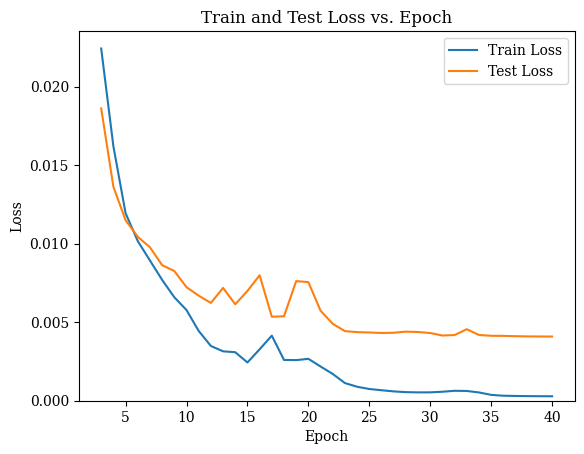

In [117]:
# prompt: plot train_loss and test_loss vs epoch
N = 2

# Assuming train_loss and test_loss are lists containing the loss values for each epoch
plt.plot(range(1+N, len(train_loss) + 1), train_loss[N:], label='Train Loss')
plt.plot(range(1+N, len(test_loss) + 1), test_loss[N:], label='Test Loss')
bottom, top = plt.ylim()  # return the current ylim
plt.ylim(0, top)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs. Epoch')
plt.legend()
plt.show()

# 🏆 Main Challenge

# ⚙️ **Fine-Tuning Task 5: Radio Signal Identification Challenge**

This challenge evaluates your ability to balance **accuracy and efficiency** while fine-tuning the model for the **Radio Signal Identification** task.

### **Objective**
Submit a solution that achieves a **score of at least 0.74**.

### **Scoring Criteria**
The final score is determined as a **weighted sum of accuracy and efficiency**, where:

- **Accuracy** reflects the model’s classification performance on the **Radio Signal Identification** task.
- **Efficiency** is based on the number of **fine-tuned parameters** from the foundation model:
  - **Fewer fine-tuned parameters** result in a better efficiency score.
  - The **number of task-head parameters** is also factored into the total count.

Your solution must **strike a balance between accuracy and efficiency** to achieve the target score.

## 📤 Challenge Submission

Submit your solution for this task along with your best-performing models for the other two tasks to the competition.

Follow this link to access the competition: [Competition Link](https://www.codabench.org/competitions/5593/?secret_key=91620f03-4ca4-4a6f-ac3d-86aba9cbf0eb)

Ensure you follow the submission guidelines provided in the link.


# **Submit Your Notebook with Hyperparameter Configurations & Performance Metrics**  

After fine-tuning your models for **Radio Signal Identification**, **Human Activity Sensing** and **5G Positioning**, please submit:  

(1) **Your final hyperparameter configurations**  
   - Learning rate (`lr`), batch size (`batch_size`), weight decay (`weight_decay`), frozen blocks (`frozen_blocks`), etc.  

(2) **Performance Metrics**  
   - **Validation accuracy**
   - **Confusion matrices**
   - **Validation Error**
   - Any other relevant evaluation metrics

This will help compare different setups and understand what worked best!



# **Mark Distribution for the Lab**

The lab is structured around fine-tuning foundation models for different tasks. Your final score will be based on completing the main tasks and subtasks.

## Total Marks: 100%

### **Mark Breakdown**

| **Task** | **Marks (%)** |
|--------------------------------------------------------------|-----------------|
| **Fine-Tuning Task 1: Human Activity Sensing** | **10%** |
| **Fine-Tuning Task 2: Radio Signal Identification** | **30%** |
| **Fine-Tuning Task 3: 5G Positioning** | **15%** |
| **Fine-Tuning Task 4: Enhancing the Classification Head** | **20%** |
| **Fine-Tuning Task 5: Radio Signal Identification Challenge** | **25%** |

---

### **Bonus Marks for Top Performing Groups**
🏆 **The top 3 performing groups in the challenge will receive bonus marks applied to their final course grade:**   
- **1st place:** +5 bonus marks  
- **2nd place:** +4 bonus marks  
- **3rd place:** +3 bonus marks  

📅 **Lab submission deadline:** February 14th  
📅 **Competition deadline:** February 28th  
